# 04. 정밀도 기반 타격 레이어링 (Layered Onset)

정밀도(onset strength 등)를 기준으로 타격을 레이어로 나누어 검토합니다.

In [27]:
import sys
import os

# 프로젝트 루트: cwd 상위로 올라가며 audio_engine + web 있는 디렉터리 (노트북 위치 무관)
def find_project_root():
    cwd = os.path.abspath(os.getcwd())
    while cwd:
        if os.path.isdir(os.path.join(cwd, 'audio_engine')) and os.path.isdir(os.path.join(cwd, 'web')):
            return cwd
        cwd = os.path.dirname(cwd)
    return os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..', '..'))  # fallback
project_root = find_project_root()
sys.path.insert(0, project_root)

import librosa
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정 (macOS 기본 폰트 사용)
plt.rcParams['font.family'] = ['AppleGothic', 'Apple SD Gothic Neo', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

print(f"프로젝트 루트: {project_root}")
print(f"Librosa 버전: {librosa.__version__}")

프로젝트 루트: /Users/laxogud/MADCAMP/W4/music-anaylzer
Librosa 버전: 0.11.0


In [28]:
# 입력: 원본 또는 드럼 스템 경로 (하나만 사용)
# 드럼 스템 예: .../stems/htdemucs/sample_ropes_short/drums.wav
audio_path = os.path.join(project_root, 'audio_engine', 'samples', 'stems', 'htdemucs', 'sample_ropes_short', 'drums.wav')
# audio_path = os.path.join(project_root, 'audio_engine', 'samples', 'sample_drum_basic_60.mp3')

if os.path.exists(audio_path):
    y, sr = librosa.load(audio_path)
    duration = len(y) / sr
    print(f"파일: {os.path.basename(audio_path)}")
    print(f"샘플링 레이트: {sr} Hz, 길이: {duration:.2f} 초")
else:
    raise FileNotFoundError(f"파일을 찾을 수 없습니다: {audio_path}")

파일: drums.wav
샘플링 레이트: 22050 Hz, 길이: 31.11 초


In [29]:
# Onset 검출 + 각 타격점의 세기(onset strength) 추출
hop_length = 256

onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
onset_frames = librosa.onset.onset_detect(
    onset_envelope=onset_env, sr=sr, hop_length=hop_length,
    delta=0.07, wait=4, backtrack=False,
)
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)
strengths = onset_env[onset_frames]

# BPM 추정 (half_win_sec adaptive용)
tempo, _ = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length)
bpm = float(tempo) if hasattr(tempo, "item") else float(tempo)

print(f"검출된 타격점 수: {len(onset_times)}")
print(f"세기 범위: {strengths.min():.4f} ~ {strengths.max():.4f}")
print(f"추정 BPM: {bpm:.1f}")

검출된 타격점 수: 126
세기 범위: 3.2242 ~ 23.8520
추정 BPM: 89.1


/var/folders/6c/v395vbb952ggdz819m67vbg80000gn/T/ipykernel_24432/3147047370.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bpm = float(tempo) if hasattr(tempo, "item") else float(tempo)


In [30]:
# Phase 1-2: 로컬 리파인 — 각 onset 주변 ±80ms만 hop_refine으로 재계산 후 피크 프레임으로 정제
hop_refine = 64
win_refine_sec = 0.08

def refine_onset_times(y, sr, onset_frames, onset_times, hop_length=256, hop_refine=64, win_refine_sec=0.08):
    n = len(onset_frames)
    onset_frames_refined = []
    onset_times_refined = []
    win_refine_frames = int(round(win_refine_sec * sr / hop_refine))
    for i in range(n):
        t = onset_times[i]
        start_s = max(0, int(round((t - win_refine_sec) * sr)))
        end_s = min(len(y), int(round((t + win_refine_sec) * sr)))
        seg = y[start_s:end_s]
        if len(seg) < hop_refine:
            onset_frames_refined.append(onset_frames[i])
            onset_times_refined.append(onset_times[i])
            continue
        env_local = librosa.onset.onset_strength(y=seg, sr=sr, hop_length=hop_refine)
        if len(env_local) == 0:
            onset_frames_refined.append(onset_frames[i])
            onset_times_refined.append(onset_times[i])
            continue
        peak_local = np.argmax(env_local)
        t_refined = start_s / sr + librosa.frames_to_time(peak_local, sr=sr, hop_length=hop_refine)
        frame_refined = librosa.time_to_frames(t_refined, sr=sr, hop_length=hop_length)
        onset_frames_refined.append(frame_refined)
        onset_times_refined.append(t_refined)
    return np.array(onset_frames_refined), np.array(onset_times_refined)

onset_frames_refined, onset_times_refined = refine_onset_times(
    y, sr, onset_frames, onset_times, hop_length=hop_length, hop_refine=hop_refine, win_refine_sec=win_refine_sec
)
onset_frames = onset_frames_refined
onset_times = onset_times_refined
strengths = onset_env[onset_frames]

print(f"정제된 타격점 수: {len(onset_times)}")

정제된 타격점 수: 126


## 1) Energy (타격 에너지) 측정

* **Phase 3**: 이벤트 i 구간을 [mid(t_{i-1}, t_i), mid(t_i, t_{i+1})] 로 정의하고, 그 구간에서 RMS 및 대역별 에너지 계산.
* **시각화/매칭**: log RMS + robust 정규화 → `energy_score` (0~1).

In [31]:
# --- 파라미터 ---
n_fft = 2048
band_hz = [(20, 150), (150, 2000), (2000, 10000)]
band_names = ["Low", "Mid", "High"]

def hz_to_bin(f_hz, sr, n_fft):
    return int(f_hz * n_fft / sr)

# --- Phase 3: 온셋 간 구간 [mid_prev, mid_next] 에서 RMS + 대역별 에너지 ---
n_events = len(onset_times)
rms_per_event = []
log_energy_per_event = []
start_samples = []
end_samples = []
left_sec_arr = []
right_sec_arr = []
band_energy = {name: [] for name in band_names}

for i in range(n_events):
    mid_prev = 0.0 if i == 0 else (onset_times[i - 1] + onset_times[i]) / 2
    mid_next = duration if i == n_events - 1 else (onset_times[i] + onset_times[i + 1]) / 2
    left_sec_arr.append(onset_times[i] - mid_prev)
    right_sec_arr.append(mid_next - onset_times[i])
    start_sample = max(0, int(round(mid_prev * sr)))
    end_sample = min(len(y), int(round(mid_next * sr)))
    start_samples.append(start_sample)
    end_samples.append(end_sample)
    seg = y[start_sample:end_sample]
    if len(seg) == 0:
        rms_per_event.append(0.0)
        log_energy_per_event.append(0.0)
        for name in band_names:
            band_energy[name].append(0.0)
        continue
    rms = np.sqrt(np.mean(seg ** 2))
    rms_per_event.append(rms)
    log_energy_per_event.append(np.log(1.0 + np.mean(seg ** 2)))
    if len(seg) < n_fft // 4:
        for name in band_names:
            band_energy[name].append(0.0)
        continue
    if len(seg) < n_fft:
        seg = np.pad(seg, (0, n_fft - len(seg)), mode="constant", constant_values=0)
    S = np.abs(np.fft.rfft(seg[:n_fft])) ** 2
    n_bins = len(S)
    for (f_lo, f_hi), name in zip(band_hz, band_names):
        b_lo = min(hz_to_bin(f_lo, sr, n_fft), n_bins - 1)
        b_hi = min(hz_to_bin(f_hi, sr, n_fft), n_bins)
        band_energy[name].append(np.sum(S[b_lo:b_hi]))

rms_per_event = np.array(rms_per_event)
log_energy_per_event = np.array(log_energy_per_event)
left_sec_arr = np.array(left_sec_arr)
right_sec_arr = np.array(right_sec_arr)
for name in band_names:
    band_energy[name] = np.array(band_energy[name])

print("이벤트 구간 에너지 (Phase 3: 온셋 간 구간 [mid_prev, mid_next])")
print(f"  RMS 범위: {rms_per_event.min():.6f} ~ {rms_per_event.max():.6f}")
print("대역별 에너지 (합)")
for name in band_names:
    arr = band_energy[name]
    print(f"  {name}: min={arr.min():.2f}, max={arr.max():.2f}, mean={arr.mean():.2f}")

이벤트 구간 에너지 (Phase 3: 온셋 간 구간 [mid_prev, mid_next])
  RMS 범위: 0.007970 ~ 0.216894
대역별 에너지 (합)
  Low: min=0.00, max=123711.32, mean=13668.39
  Mid: min=0.01, max=59913.43, mean=7163.04
  High: min=0.00, max=25046.17, mean=1812.23


In [32]:
# --- 순위 없음: 실제 값 기준. log RMS + robust 정규화 → 0~1 ---
def robust_norm(x):
    """median, MAD 기반 정규화 → 0~1 (값 기준, 순위 아님)"""
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    if mad < 1e-12:
        return np.zeros_like(x) + 0.5
    z = (x - med) / (1.4826 * mad)
    return np.clip(0.5 + z / 6, 0, 1)

log_rms = np.log(1e-10 + rms_per_event)
energy_score = robust_norm(log_rms)
E_norm = energy_score
E_norm_low = robust_norm(band_energy["Low"])
E_norm_mid = robust_norm(band_energy["Mid"])
E_norm_high = robust_norm(band_energy["High"])

print("실제 값 기준 (순위 없음): log RMS + robust 정규화")
print(f"  log_rms: min={log_rms.min():.4f}, max={log_rms.max():.4f}")
print(f"  energy_score (0~1): min={energy_score.min():.4f}, max={energy_score.max():.4f}")

실제 값 기준 (순위 없음): log RMS + robust 정규화
  log_rms: min=-4.8321, max=-1.5283
  energy_score (0~1): min=0.0000, max=0.6277


---

## 원인 분석: 같은 드럼 비트인데 E_norm/RMS가 다르게 나오는 경우

가변 윈도우(이벤트별 left/right) 기준 겹침: gap_prev[i] < (left_sec_arr[i] + right_sec_arr[i-1]) 이면 이전 onset과 윈도우 겹침.

In [33]:
# --- 가변 윈도우 기준 겹침 ---
deltas = np.diff(onset_times)
gap_prev = np.concatenate([[np.inf], deltas])
overlap_prev = np.zeros(n_events, dtype=bool)
for i in range(1, n_events):
    overlap_prev[i] = gap_prev[i] < (left_sec_arr[i] + right_sec_arr[i - 1])

win_total_sec_median = np.median(left_sec_arr + right_sec_arr) * 2  # 대표 윈도우 길이 (가변)
print("1) Onset 간격 & 윈도우 겹침 (가변 윈도우 기준)")
print(f"   대표 윈도우 길이(median): {win_total_sec_median*1000:.1f} ms")
print(f"   onset 간격: min={deltas.min()*1000:.0f} ms, max={deltas.max()*1000:.0f} ms, median={np.median(deltas)*1000:.0f} ms")
print(f"   이전 onset과 겹치는 이벤트 수: {overlap_prev.sum()} / {n_events}")
if overlap_prev.any():
    print(f"   → 겹침 구간의 E_norm: mean={E_norm[overlap_prev].mean():.3f}, std={E_norm[overlap_prev].std():.3f}")
    print(f"   → 겹침 없는 구간의 E_norm: mean={E_norm[~overlap_prev].mean():.3f}, std={E_norm[~overlap_prev].std():.3f}")

1) Onset 간격 & 윈도우 겹침 (가변 윈도우 기준)
   대표 윈도우 길이(median): 351.2 ms
   onset 간격: min=0 ms, max=2664 ms, median=215 ms
   이전 onset과 겹치는 이벤트 수: 0 / 126


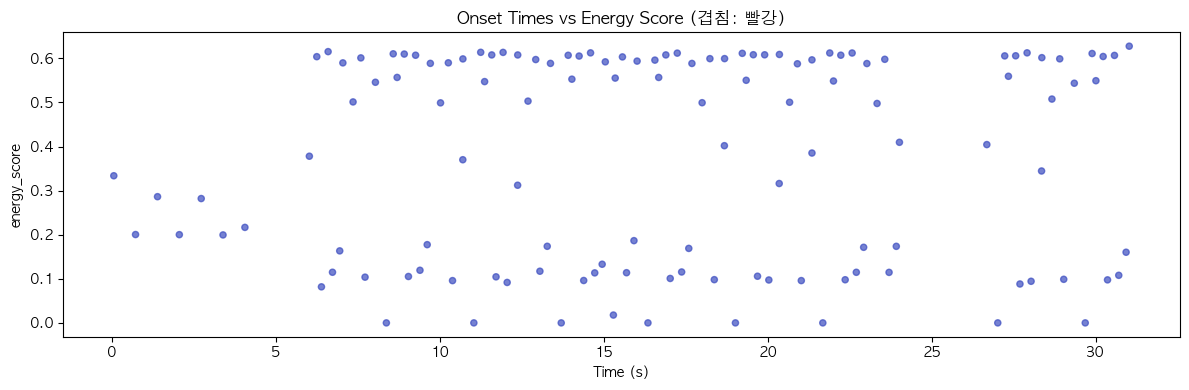

In [34]:
# 시각화: onset_times vs energy_score
plt.figure(figsize=(12, 4))
plt.scatter(onset_times, E_norm, c=overlap_prev.astype(float), cmap="coolwarm", alpha=0.7, s=20)
plt.xlabel('Time (s)')
plt.ylabel('energy_score')
plt.title('Onset Times vs Energy Score (겹침: 빨강)')
plt.tight_layout()
plt.show()

In [36]:
# JSON 내보내기 — web 양식(parseEnergyJson) + 다양한 값
import json
import shutil

# 웹 파서: 루트에 source, sr, duration_sec, energy_rms_min, energy_rms_max, events 필요
rms_min, rms_max = float(rms_per_event.min()), float(rms_per_event.max())
out = {
    "source": os.path.basename(audio_path),
    "sr": int(sr),
    "duration_sec": round(float(duration), 4),
    "energy_rms_min": round(rms_min, 6),
    "energy_rms_max": round(rms_max, 6),
    "hop_length": int(hop_length),
    "bpm": round(float(bpm), 2),
    "total_events": len(onset_times),
    "events": []
}

DEFAULT_POINT_COLOR = "#5a9fd4"
for i in range(len(onset_times)):
    t = round(float(onset_times[i]), 4)
    esc = float(energy_score[i])
    out["events"].append({
        # 웹 시각화용 (Tab04EnergyView / parseEnergyJson)
        "t": t,
        "time": t,
        "strength": round(esc, 4),
        "texture": round(float(E_norm_high[i]), 4),
        "color": DEFAULT_POINT_COLOR,
        "rms": round(float(rms_per_event[i]), 6),
        "e_norm": round(esc, 4),
        "band_low": round(float(E_norm_low[i]), 4),
        "band_mid": round(float(E_norm_mid[i]), 4),
        "band_high": round(float(E_norm_high[i]), 4),
        # 추가 값 (다양한 분석용)
        "index": i,
        "frame": int(onset_frames[i]),
        "onset_strength": round(float(strengths[i]), 4),
        "log_rms": round(float(log_rms[i]), 4),
        "energy_score": round(esc, 4),
        "E_norm_low": round(float(E_norm_low[i]), 4),
        "E_norm_mid": round(float(E_norm_mid[i]), 4),
        "E_norm_high": round(float(E_norm_high[i]), 4),
        "left_sec": round(float(left_sec_arr[i]), 4),
        "right_sec": round(float(right_sec_arr[i]), 4),
        "overlap_prev": bool(overlap_prev[i]),
    })

samples_dir = os.path.join(project_root, "audio_engine", "samples")
os.makedirs(samples_dir, exist_ok=True)
json_path = os.path.join(samples_dir, "onset_events_energy.json")

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False, indent=2)

web_public = os.path.join(project_root, "web", "public")
if os.path.isdir(web_public):
    shutil.copy(json_path, os.path.join(web_public, "onset_events_energy.json"))
    print("웹 public 복사 완료: web/public/onset_events_energy.json")

print(f"저장 완료: {json_path}")

웹 public 복사 완료: web/public/onset_events_energy.json
저장 완료: /Users/laxogud/MADCAMP/W4/music-anaylzer/audio_engine/samples/onset_events_energy.json
